Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
from glob import glob
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Reading CFAR filtered images

In [2]:
files2=glob("/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/Jannah FYP/Documents/Sonar Repositories/soca_test/Polar Input/fls_images_polar/*.png")
binary_image=cv2.imread(files2[5],0)
binary_image=cv2.rotate(binary_image,1)


Sanity Check

In [3]:
r,binary_image=cv2.threshold(binary_image,100,255,cv2.THRESH_BINARY)

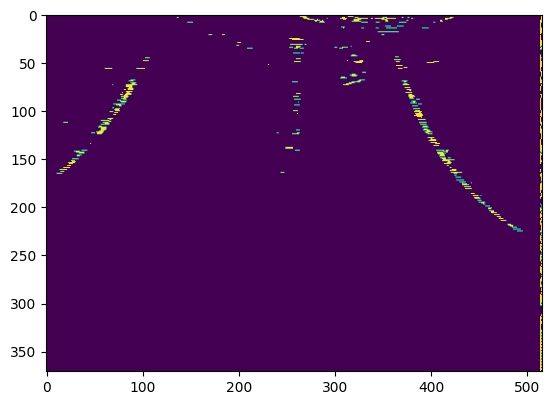

In [4]:
binary_image=binary_image//255
plt.imshow(binary_image)

Trying a non Open3D way of visualizing height maps

Where height = range * tan (vertical field of view /2) --> Better to visualize with paper

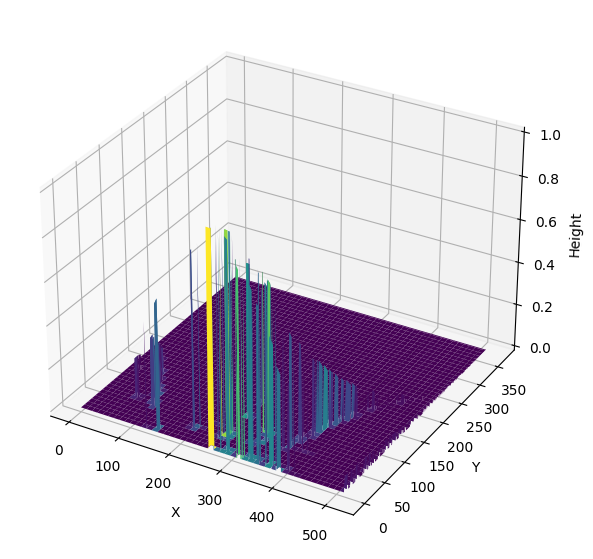

In [5]:


# Generate a 2D binary image
H, W = binary_image.shape

# Sensor origin (bottom center)
x0, y0 = W // 2, 0

# Compute distance and Gaussian parameters
distances = np.zeros_like(binary_image, dtype=float)
sigma_min, k = 100, 0.05  # Gaussian scaling parameters
gaussian_grid = np.zeros((H, W))

for y in range(H):
    for x in range(W):
        if binary_image[y, x] > 0:
            # Compute distance from sensor
            d = np.sqrt((x - x0)**2 + (y - y0)**2)
            distances[y, x] = d
            # Compute Gaussian size
            sigma = sigma_min + k * d
            # Add Gaussian to grid
            gaussian_grid[y, x] = np.exp(-0.5 * (d / sigma)**2)

# Visualization in 3D
X, Y = np.meshgrid(np.arange(W), np.arange(H))
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, gaussian_grid, cmap='viridis')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Height")
plt.show()


The Open3D way, with some coloring scheme (red being high probability, blue being least)

In [5]:
# H, W = 100, 100
# binary_image = np.zeros((H, W))
# circle_center = (50, 50)  # Center of the circle
# circle_radius = 35        # Radius of the circle

# # Create circular boundary
# for y in range(H):
#     for x in range(W):
#         # Check if the point is within the circle
#         if np.sqrt((x - circle_center[0])**2 + (y - circle_center[1])**2) <= circle_radius:
#             binary_image[y, x] = 1

# Sensor origin (bottom center)
H, W = binary_image.shape
x0, y0 = W // 2, 0

# Parameters for Gaussian and uncertainty
sigma_min, k = 50, 0.5  # Gaussian scaling parameters
max_radius = 50  # Circular boundary radius
gaussian_grid = np.zeros((H, W))
uncertainty_grid = np.zeros((H, W))

# Compute Gaussian values and uncertainty
for y in range(H):
    for x in range(W):
        # Compute distance from sensor
        d = np.sqrt((x - x0)**2 + (y - y0)**2)
        if binary_image[y, x] > 0:
            # Compute Gaussian size
            sigma = sigma_min + k * d
            # Add Gaussian to grid
            gaussian_grid[y, x] = np.exp(-0.5 *(d / sigma)**2)
            # Compute uncertainty (inverse of height)
            uncertainty_grid[y, x] = 1 - gaussian_grid[y, x]

# Convert to point cloud for Open3D visualization
points = []
colors = []

for y in range(H):
    for x in range(W):
 # Consider only points within the circular boundary
        z = 100*gaussian_grid[y, x]
        z_vals=np.linspace(-z,z,10)
        certainty = 1 - uncertainty_grid[y, x]
        for z_val in z_vals:
            points.append([x,y,z_val])
            
            colors.append([certainty, 1-certainty, 0])  # Red to green gradient
        # Map uncertainty to color (red = high certainty)
        
        #colors.append([certainty, 1-certainty, 0])  # Red to green gradient
# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize with Open3D
o3d.visualization.draw_geometries([pcd], window_name="Gaussian Height Map")

Trying to plot histograms

In [54]:
vals=[]
for x in range(H):
    for y in range(W):
        vals.append(gaussian_grid[y,x])

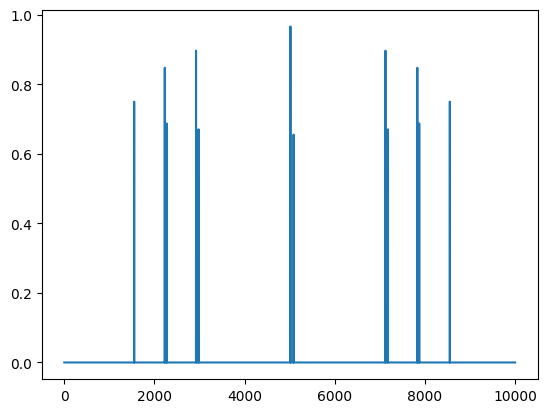

In [55]:
plt.plot(vals)